# Determine natural and total ERF from RFMIP Tier 2

RFMIP models
- CanESM5
- CNRM-CM6-1
- HadGEM3-GC31-LL
- IPSL-CM6A
- MIROC6
- NorESM-LM
- GISS-E2-1-G
- GFDL-CM4

AerChemMIP models (aerosol forcing only)
- E3SM
- GFDL-ESM4
- MRI-ESM2-0
- UKESM1-0-LL

In [1]:
import iris
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import warnings
import glob
from iris.experimental.equalise_cubes import equalise_attributes
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
from fair.forcing.ghg import etminan

In [2]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 10
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
#pl.rcParams['figure.dpi'] = 300

In [3]:
warnings.simplefilter('ignore')

In [4]:
def format_cube(cube, field, filename):
    """
    This dataset is a raw dump of our archived data.
    As such we need to do some metadata parsing to make our lives easier.
    In this case we're just going to add an extra 'realization' coordinate,
    but we can put anything in here, as long as a cube is returned at the end.
    """
    if not cube.coords('realization'):
        realization = int(filename.split('/')[9][1])
        realization_coord = iris.coords.AuxCoord(
            realization, standard_name='realization', var_name='realization')
        cube.add_aux_coord(realization_coord)
        return cube

Get 2014 CO2 and GHG forcing values from time slice runs

In [5]:
startyears_co2 = {
    'CanESM5'     : 1,
    'CNRM-CM6-1'  : 5,
    'GFDL-CM4'    : 1,
    'GISS-E2-1-G' : 5,
    'HadGEM3-GC31-LL': 1,
    'IPSL-CM6A-LR': 10,
    'MIROC6'      : 1,
    'NorESM2-LM'  : 1,
}


In [6]:
models = ['CanESM5', 'CNRM-CM6-1', 'E3SM', 'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM', 'UKESM1-0-LL']

endyear = {
    'CanESM5'    : 2100,
    'MIROC6'     : 2100,
    'NorESM2-LM' : 2014,
    'GISS-E2-1-G': 2100,
    'HadGEM3-GC31-LL': 2099,
    'GFDL-CM4'   : 2100,
    'E3SM'       : 2014,
    'UKESM1-0-LL': 2014,
    'GFDL-ESM4'  : 2014,
    'IPSL-CM6A-LR': 2100,
    'CNRM-CM6-1' : 2014,
    'MRI-ESM2-0' : 2014,
}

startyear = {
    'CanESM5'    : 1850,
    'MIROC6'     : 1850,
    'NorESM2-LM' : 1850,
    'GISS-E2-1-G': 1850,
    'HadGEM3-GC31-LL': 1850,
    'GFDL-CM4'   : 1850,
    'E3SM'       : 1870,
    'GFDL-ESM4'  : 1850,
    'UKESM1-0-LL': 1850,
    'IPSL-CM6A-LR': 1850,
    'CNRM-CM6-1' : 1850,
    'MRI-ESM2-0': 1850,
}

cubes = {}
models_subset1 = ['CanESM5', 'CNRM-CM6-1', 'GFDL-CM4', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM']
for model in models_subset1:
    cubes[model] = {}
    for expt in ['4xCO2', 'ghg', 'anthro']:
        cubes[model][expt] = {}
        for var in ['erf_sw', 'erf_lw', 'erf']:
            if model=='GISS-E2-1-G':
                filenames = glob.glob(
                    '/nfs/a65/pmcjs/RFMIP/RFMIP-ERF/%s/adjust/aprp/r1i1p1f2/piClim-%s/globalmeanyearmean/%s.nc' % (model,expt,var))
            elif model=='IPSL-CM6A-LR':
                filenames = glob.glob(
                    '/nfs/a65/pmcjs/RFMIP/RFMIP-ERF/%s/adjust/HadGEM3_TOA_L19/r?i?p?f1/piClim-%s/globalmeanyearmean/%s.nc' % (model,expt,var))
            else:
                filenames = glob.glob(
                    '/nfs/a65/pmcjs/RFMIP/RFMIP-ERF/%s/adjust/HadGEM3_TOA_L19/r?i?p?f?/piClim-%s/globalmeanyearmean/%s.nc' % (model,expt,var))
#             if len(filenames)>0:
#                 indata = iris.load_cube(filenames, callback=format_cube)
#                 print(indata.data[startyears_co2[model]:])
#                 cubes[model][expt][var] = np.mean(indata.data[startyears_co2[model]:])
            indata = iris.load_cube(filenames, callback=format_cube)
            if indata.ndim == 2:
                cubes[model][expt][var] = np.mean(indata.collapsed(['realization'], iris.analysis.MEAN).data[startyears_co2[model]:])
            else:
                cubes[model][expt][var] = np.mean(indata.data[startyears_co2[model]:])
            print(model, expt, var, cubes[model][expt][var])
                
models_subset2 = ['E3SM', 'UKESM1-0-LL', 'GFDL-ESM4', 'MRI-ESM2-0']
for model in models_subset2:
    cubes[model] = {}
    print(model)
    for var in ['erf_sw', 'erf_lw', 'erf']:
        cubes[model][var] = iris.load_cube(filenames, callback=format_cube)
        if cubes[model][var].ndim == 2:
            cubes[model][var] = cubes[model][var].collapsed(['realization'], iris.analysis.MEAN)
        if model=='E3SM':
            cubes[model][var] = cubes[model][var] * (-1)

CanESM5 4xCO2 erf_sw 1.9123115905248746
CanESM5 4xCO2 erf_lw 5.695051062098308
CanESM5 4xCO2 erf 7.607362652672368
CanESM5 ghg erf_sw 0.8094237190213106
CanESM5 ghg erf_lw 2.0571226150216226
CanESM5 ghg erf 2.8665463345516327
CanESM5 anthro erf_sw 0.05690733395946145
CanESM5 anthro erf_lw 2.3168350570330984
CanESM5 anthro erf 2.3737423916825313
CNRM-CM6-1 4xCO2 erf_sw 2.1553356730218325
CNRM-CM6-1 4xCO2 erf_lw 5.843778125510104
CNRM-CM6-1 4xCO2 erf 7.99911379840334
CNRM-CM6-1 ghg erf_sw 0.5206928926706185
CNRM-CM6-1 ghg erf_lw 2.2220593265203625
CNRM-CM6-1 ghg erf 2.742752219165134
CNRM-CM6-1 anthro erf_sw -0.745748395138103
CNRM-CM6-1 anthro erf_lw 2.3571308702618627
CNRM-CM6-1 anthro erf 1.6113824749825505
GFDL-CM4 4xCO2 erf_sw 2.296735860753795
GFDL-CM4 4xCO2 erf_lw 5.939405533773764
GFDL-CM4 4xCO2 erf 8.236141393946994
GFDL-CM4 ghg erf_sw 0.7891321425178345
GFDL-CM4 ghg erf_lw 2.3446278827207547
GFDL-CM4 ghg erf 3.1337600251272364
GFDL-CM4 anthro erf_sw -0.2841229082056053
GFDL-CM4

In [7]:
for model in models_subset1:
    print(model,cubes[model]['4xCO2']['erf'])

CanESM5 7.607362652672368
CNRM-CM6-1 7.99911379840334
GFDL-CM4 8.236141393946994
GISS-E2-1-G 7.2680369476089
HadGEM3-GC31-LL 8.089091209294017
IPSL-CM6A-LR 8.001209919838109
MIROC6 7.323934862461696
NorESM2-LM 8.151879002144954


In [8]:
df_rcmip = pd.read_csv('/nfs/b0110/Users/mencsm/ar6/data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')
conc = {}
conc['CO2'] = np.squeeze(df_rcmip[(df_rcmip.Scenario=='ssp245')&(df_rcmip.Variable=='Atmospheric Concentrations|CO2')&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)
conc['CH4'] = np.squeeze(df_rcmip[(df_rcmip.Scenario=='ssp245')&(df_rcmip.Variable=='Atmospheric Concentrations|CH4')&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)
conc['N2O'] = np.squeeze(df_rcmip[(df_rcmip.Scenario=='ssp245')&(df_rcmip.Variable=='Atmospheric Concentrations|N2O')&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)

In [9]:
#df_rcmip

In [10]:
gases=['HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
      'NF3','C2F6','C3F8','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
      'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
      'Halon1301','Halon2402']
for gas in gases:
    conc[gas] = np.squeeze(df_rcmip[(df_rcmip.Scenario=='ssp245')&(df_rcmip.Variable.str.endswith(gas))&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)
    #print(conc[gas])
    
radeff = {
    'HFC125':     0.23,
    'HFC134a':    0.16,
    'HFC143a':    0.16,
    'HFC152a':    0.10,
    'HFC227ea':   0.26,
    'HFC23':      0.18,
    'HFC236fa':   0.24309707,
    'HFC245fa':   0.24,
    'HFC32':      0.11,
    'HFC365mfc':  0.22261699,
    'HFC4310mee': 0.42,
    'NF3':        0.20467908,
    'C2F6':       0.25,
    'C3F8':       0.27730479,
    'C4F10':      0.36298028,
    'C5F12':      0.40512062,
    'C6F14':      0.44,
    'C7F16':      0.50171525,
    'C8F18':      0.55174034,
    'CF4':        0.09,
    'cC4F8':      0.31526465,
    'SF6':        0.57,
    'SO2F2':      0.20119879,
    'CCl4':       0.17,
    'CFC11':      0.26,
    'CFC113':     0.30,
    'CFC114':     0.31,
    'CFC115':     0.20,
    'CFC12':      0.32,
    'CH2Cl2':     0.0312,
    'CH3Br':      0.004,
    'CH3CCl3':    0.07,
    'CH3Cl':      0.01,
    'CHCl3':      0.07796969,
    'HCFC141b':   0.16,
    'HCFC142b':   0.19,
    'HCFC22':     0.21,
    'Halon1211':  0.29,
    'Halon1301':  0.30,
    'Halon2402':  0.31
}

forcing_other = np.zeros(251)
for gas in gases:
    for i,year in enumerate(range(1850,2101)):
        forcing_other[i] = forcing_other[i] + ((conc[gas][i] - conc[gas][0]) * radeff[gas] * 0.001)
forcing_other[164]

0.3683037471504431

In [11]:
colors = {
    'CanESM5'    :  'red',#'#1e4c24',
    'CNRM-CM6-1' : 'orangered',
    'E3SM'       : 'darkorange',
    'GFDL-ESM4'  : 'yellow', 
    'GFDL-CM4'   : 'yellowgreen',#'green',
    'GISS-E2-1-G':  'green',#'#771d7b',
    'HadGEM3-GC31-LL': 'turquoise',
    'IPSL-CM6A-LR': 'teal',
    'MIROC6'     :  'blue',#b85fb7',
    'MRI-ESM2-0': 'indigo',
    'NorESM2-LM' :  'purple',#'red',
    'UKESM1-0-LL': 'crimson',
    'mean'       : 'black',
    'AR5'         : '0.6',
    'AR6'         : '0.3',
    'Lund'        : 'pink',
}

for model in models:
    cubes[model]['histanthro'] = {}
    for expt in ['histall', 'histnat', 'histghg', 'histaer']:
        cubes[model][expt] = {}
        for var in ['erf_sw', 'erf_lw', 'erf']:
            #print(model, expt, var)
            cubes[model][expt][var] = np.ones(251) * np.nan
            if model=='GISS-E2-1-G':
                filenames = glob.glob(
                    '/nfs/a65/pmcjs/RFMIP/RFMIP-ERF/%s/adjust/aprp/r1i1p1f2/piClim-%s/globalmeanyearmean/%s.nc' % (model,expt,var))
            elif model=='NorESM2-LM':
                filenames = glob.glob(
                    '/nfs/a65/pmcjs/RFMIP/RFMIP-ERF/%s/adjust/aprp/r?i1p1f1/piClim-%s/globalmeanyearmean/%s.nc' % (model,expt,var))                
            else:
                filenames = glob.glob(
                    '/nfs/a65/pmcjs/RFMIP/RFMIP-ERF/%s/adjust/aprp/r?i?p?f?/piClim-%s/globalmeanyearmean/%s.nc' % (model,expt,var))
            if len(filenames)>0:
                indata = iris.load_cube(filenames, callback=format_cube)
                if indata.ndim == 2:
                    cubes[model][expt][var][(startyear[model]-1850):(endyear[model]-1850+1)] = indata.collapsed(['realization'], iris.analysis.MEAN).data[:(endyear[model]-startyear[model]+1)]
                else:
                    #print(cubes[model][expt][var][:(endyear[model]-1850+1)], indata)
                    cubes[model][expt][var][(startyear[model]-1850):(endyear[model]-1850+1)] = indata.data[:(endyear[model]-startyear[model]+1)]
    for var in ['erf_sw', 'erf_lw', 'erf']:
        cubes[model]['histanthro'][var] = cubes[model]['histall'][var]-cubes[model]['histnat'][var]

In [12]:
etminan_2014_4x_ratio = etminan([conc['CO2'][164],conc['CH4'][0],conc['N2O'][0]],[conc['CO2'][0],conc['CH4'][0],conc['N2O'][0]], scale_F2x=False)[0]/etminan([4*conc['CO2'][0],conc['CH4'][0],conc['N2O'][0]],[conc['CO2'][0],conc['CH4'][0],conc['N2O'][0]], scale_F2x=False)[0]
etminan_2014_all      = etminan([conc['CO2'][164],conc['CH4'][164],conc['N2O'][164]],[conc['CO2'][0],conc['CH4'][0],conc['N2O'][0]], scale_F2x=False)[0]
etminan_2014_all

1.8019753086794583

In [13]:
for model in models_subset1:
    cubes[model]['histco2'] = {}
    cubes[model]['histco2']['erf'] = np.zeros(251)
    cubes[model]['histnonco2ghg'] = {}
    cubes[model]['histnonco2'] = {}
    for i in range(251):
        cubes[model]['histco2']['erf'][i] = (etminan([conc['CO2'][i],conc['CH4'][i],conc['N2O'][i]], [conc['CO2'][0],conc['CH4'][0],conc['N2O'][0]], scale_F2x=False)*np.array([cubes[model]['4xCO2']['erf']*etminan_2014_4x_ratio/etminan_2014_all, 1,1]))[0]#, forcing_other[i])
    cubes[model]['histnonco2ghg']['erf'] = cubes[model]['histghg']['erf'] - cubes[model]['histco2']['erf']
    cubes[model]['histnonco2']['erf'] = cubes[model]['histall']['erf'] - cubes[model]['histco2']['erf']
    
    print(model, cubes[model]['4xCO2']['erf'])
    print(model, cubes[model]['ghg']['erf'])
    print(model, cubes[model]['4xCO2']['erf']*etminan_2014_4x_ratio)
    print(model, cubes[model]['4xCO2']['erf']*etminan_2014_4x_ratio/etminan_2014_all)
    print()

CanESM5 7.607362652672368
CanESM5 2.8665463345516327
CanESM5 1.7238836465527578
CanESM5 0.9566633006842206

CNRM-CM6-1 7.99911379840334
CNRM-CM6-1 2.742752219165134
CNRM-CM6-1 1.8126573023487902
CNRM-CM6-1 1.0059279356481083

GFDL-CM4 8.236141393946994
GFDL-CM4 3.1337600251272364
GFDL-CM4 1.8663694775657673
GFDL-CM4 1.0357353225519494

GISS-E2-1-G 7.2680369476089
GISS-E2-1-G 2.807340692057969
GISS-E2-1-G 1.6469899764963674
GISS-E2-1-G 0.9139914229475936

HadGEM3-GC31-LL 8.089091209294017
HadGEM3-GC31-LL 3.1059810957127403
HadGEM3-GC31-LL 1.833046837365779
HadGEM3-GC31-LL 1.017243037979855

IPSL-CM6A-LR 8.001209919838109
IPSL-CM6A-LR 2.818961845092238
IPSL-CM6A-LR 1.813132298694773
IPSL-CM6A-LR 1.0061915332366518

MIROC6 7.323934862461696
MIROC6 2.6877963299949212
MIROC6 1.6596568501148194
MIROC6 0.9210208608968488

NorESM2-LM 8.151879002144954
NorESM2-LM 2.797050923374114
NorESM2-LM 1.8472750073953554
NorESM2-LM 1.0251389120026813



In [14]:
# fig, ax = pl.subplots(2,3,figsize=(20/2.54,14/2.54))
# for i, model in enumerate(models_subset1):
#     ax[i//3, i%3].plot(np.arange(1850, 2101),cubes[model]['histco2']['erf'], label='CO2')
#     ax[i//3, i%3].plot(np.arange(1850, 2101),cubes[model]['histnonco2ghg']['erf'], label='non-CO2 GHGs')
#     ax[i//3, i%3].plot(np.arange(1850, 2101),cubes[model]['histall']['erf'], label='All')
#     ax[i//3, i%3].plot(np.arange(1850, 2101),cubes[model]['histaer']['erf'], label='Aerosols')
#     ax[i//3, i%3].plot(np.arange(1850, 2101),cubes[model]['histnat']['erf'], label='Natural')
#     #ax[i//3, i%3].legend()
#     ax[i//3, i%3].set_title(model)

In [15]:
# fig, ax = pl.subplots(2,4,figsize=(20/2.54,14/2.54))
# for i, model in enumerate(models_subset1):
#     ax[i//3, i%3].plot(np.arange(1850, 2101),cubes[model]['histco2']['erf'], label='CO2 forcing', color=colors[model], ls='-')
#     ax[i//3, i%3].plot(np.arange(1850, 2101),cubes[model]['histnonco2']['erf'], label='non CO2 forcing', color=colors[model], ls='--')
#     ax[i//3, i%3].set_title(model)

Before running this next cell, you need to generate the APRP currently in `cmip6_fair` directory

## ERF: net

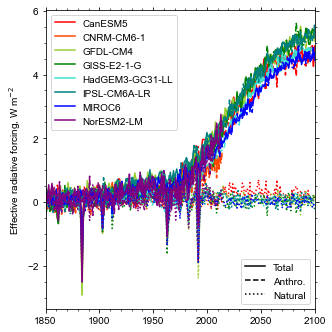

In [16]:
fig,ax=pl.subplots()#(figsize=(16,9))
for model in models_subset1:
    pl.plot(np.arange(1850,2101), cubes[model]['histall']['erf'].data, label=model, color=colors[model], ls='-')
    pl.plot(np.arange(1850,2101), cubes[model]['histanthro']['erf'].data, color=colors[model], ls='--')
    pl.plot(np.arange(1850,2101), cubes[model]['histnat']['erf'].data, color=colors[model], ls=':')
l1 = pl.legend(loc='upper left')
pl.gca().add_artist(l1)

custom_lines = [Line2D([0], [0], color='k', ls='-'),
                Line2D([0], [0], color='k', ls='--'),
                Line2D([0], [0], color='k', ls=':')]

pl.legend(custom_lines, ['Total', 'Anthro.', 'Natural'], loc='lower right');

pl.ylabel('Effective radiative forcing, W m$^{-2}$')
pl.xlim(1850,2100);

pl.tight_layout()
pl.savefig('../plots/RFMIP-ERF_tier2.png')

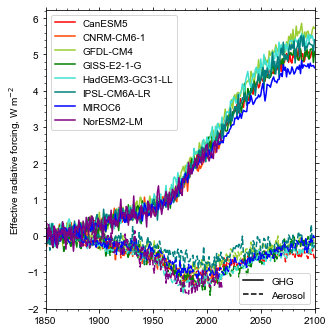

In [17]:
fig,ax=pl.subplots()#(figsize=(16,9))
for model in models_subset1:
    pl.plot(np.arange(1850,2101), cubes[model]['histghg']['erf'].data, label=model, color=colors[model], ls='-')
    pl.plot(np.arange(1850,2101), cubes[model]['histaer']['erf'].data, color=colors[model], ls='--')
l1 = pl.legend(loc='upper left')
pl.gca().add_artist(l1)

custom_lines = [Line2D([0], [0], color='k', ls='-'),
                Line2D([0], [0], color='k', ls='--')]

pl.legend(custom_lines, ['GHG', 'Aerosol'], loc='lower right');

pl.ylabel('Effective radiative forcing, W m$^{-2}$')
pl.xlim(1850,2100);

pl.tight_layout()
pl.savefig('../plots/RFMIP-ERF_tier2_ghg_aerosol.png')

In [18]:
-cubes['E3SM']['histaer']['erf']

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -0.35862465, -0.02201866, -0.11903937, -0.29557014, -0.32191201,
       -0.08130301, -0.22005405, -0.42839641, -0.17943999, -0.17923519,
       -0.1915628 , -0.06955399,  0.01434313, -0.18444054, -0.24570824,
       -0.31462709,  0.06545709, -0.05167372, -0.38488964, -0.29753978,
       -0.14591141,  0.03209495, -0.31210631, -0.49878627, -0.61498705,
       -0.36736926, -0.11407421, -0.41908469, -0.23988987, -0.37093626,
       -0.30391537, -0.40595148, -0.34664383, -0.26581908, -0.58560967,
       -0.52006184, -0.38706546, -0.44709765, -0.72591529, -0.74710147,
       -0.68735357, -0.47573019, -0.4498553 , -0.65977787, -0.1655718 ,
       -0.39058231, -0.40573432, -0.43636767, -0.77002652, -0.39

In [19]:
df = pd.DataFrame(
    data={
        'year':             np.arange(1850,2101),
        'CanESM5 CO2':      cubes['CanESM5']['histco2']['erf'],
        'CanESM5 nonCO2':   cubes['CanESM5']['histnonco2']['erf'],
        'CanESM5 ANT':      cubes['CanESM5']['histanthro']['erf'],
        'CanESM5 GHG':      cubes['CanESM5']['histghg']['erf'],
        'CanESM5 AER':      cubes['CanESM5']['histaer']['erf'],
        'CanESM5 NAT':      cubes['CanESM5']['histnat']['erf'],
        'CanESM5 TOT':      cubes['CanESM5']['histall']['erf'],
        'CNRM-CM6-1 CO2':   cubes['CNRM-CM6-1']['histco2']['erf'],
        'CNRM-CM6-1 nonCO2': cubes['CNRM-CM6-1']['histnonco2']['erf'],
        'CNRM-CM6-1 ANT':   cubes['CNRM-CM6-1']['histanthro']['erf'],
        'CNRM-CM6-1 GHG':   cubes['CNRM-CM6-1']['histghg']['erf'],
        'CNRM-CM6-1 AER':   cubes['CNRM-CM6-1']['histaer']['erf'],
        'CNRM-CM6-1 NAT':   cubes['CNRM-CM6-1']['histnat']['erf'],
        'CNRM-CM6-1 TOT':   cubes['CNRM-CM6-1']['histall']['erf'],
        'E3SM AER':         -cubes['E3SM']['histaer']['erf'],
        'GFDL-CM4 CO2':     cubes['GFDL-CM4']['histco2']['erf'],
        'GFDL-CM4 nonCO2':  cubes['GFDL-CM4']['histnonco2']['erf'],
        'GFDL-CM4 ANT':     cubes['GFDL-CM4']['histanthro']['erf'],
        'GFDL-CM4 GHG':     cubes['GFDL-CM4']['histghg']['erf'],
        'GFDL-CM4 AER':     cubes['GFDL-CM4']['histaer']['erf'],
        'GFDL-CM4 NAT':     cubes['GFDL-CM4']['histnat']['erf'],
        'GFDL-CM4 TOT':     cubes['GFDL-CM4']['histall']['erf'],
        'GFDL-ESM4 AER':    cubes['GFDL-ESM4']['histaer']['erf'],
        'GISS-E2-1-G CO2':  cubes['GISS-E2-1-G']['histco2']['erf'],
        'GISS-E2-1-G nonCO2':cubes['GISS-E2-1-G']['histnonco2']['erf'],
        'GISS-E2-1-G ANT':  cubes['GISS-E2-1-G']['histanthro']['erf'],
        'GISS-E2-1-G GHG':  cubes['GISS-E2-1-G']['histghg']['erf'],
        'GISS-E2-1-G AER':  cubes['GISS-E2-1-G']['histaer']['erf'],
        'GISS-E2-1-G NAT':  cubes['GISS-E2-1-G']['histnat']['erf'],
        'GISS-E2-1-G TOT':  cubes['GISS-E2-1-G']['histall']['erf'],
        'HadGEM3-GC31-LL CO2':  cubes['HadGEM3-GC31-LL']['histco2']['erf'],
        'HadGEM3-GC31-LL nonCO2':cubes['HadGEM3-GC31-LL']['histnonco2']['erf'],
        'HadGEM3-GC31-LL ANT':  cubes['HadGEM3-GC31-LL']['histanthro']['erf'],
        'HadGEM3-GC31-LL GHG':  cubes['HadGEM3-GC31-LL']['histghg']['erf'],
        'HadGEM3-GC31-LL AER':  cubes['HadGEM3-GC31-LL']['histaer']['erf'],
        'HadGEM3-GC31-LL NAT':  cubes['HadGEM3-GC31-LL']['histnat']['erf'],
        'HadGEM3-GC31-LL TOT':  cubes['HadGEM3-GC31-LL']['histall']['erf'],
        'IPSL-CM6A-LR CO2':  cubes['IPSL-CM6A-LR']['histco2']['erf'],
        'IPSL-CM6A-LR nonCO2':cubes['IPSL-CM6A-LR']['histnonco2']['erf'],
        'IPSL-CM6A-LR ANT':  cubes['IPSL-CM6A-LR']['histanthro']['erf'],
        'IPSL-CM6A-LR GHG':  cubes['IPSL-CM6A-LR']['histghg']['erf'],
        'IPSL-CM6A-LR AER':  cubes['IPSL-CM6A-LR']['histaer']['erf'],
        'IPSL-CM6A-LR NAT':  cubes['IPSL-CM6A-LR']['histnat']['erf'],
        'IPSL-CM6A-LR TOT':  cubes['IPSL-CM6A-LR']['histall']['erf'],
        'MIROC6 CO2':       cubes['MIROC6']['histco2']['erf'],
        'MIROC6 nonCO2':    cubes['MIROC6']['histnonco2']['erf'],
        'MIROC6 ANT':       cubes['MIROC6']['histanthro']['erf'],
        'MIROC6 GHG':       cubes['MIROC6']['histghg']['erf'],
        'MIROC6 AER':       cubes['MIROC6']['histaer']['erf'],
        'MIROC6 NAT':       cubes['MIROC6']['histnat']['erf'],
        'MIROC6 TOT':       cubes['MIROC6']['histall']['erf'],
        'MRI-ESM2-0 AER':   cubes['MRI-ESM2-0']['histaer']['erf'],
        'NorESM2-LM CO2':   cubes['NorESM2-LM']['histco2']['erf'],
        'NorESM2-LM nonCO2':cubes['NorESM2-LM']['histnonco2']['erf'],
        'NorESM2-LM ANT':   cubes['NorESM2-LM']['histanthro']['erf'],
        'NorESM2-LM GHG':   cubes['NorESM2-LM']['histghg']['erf'],
        'NorESM2-LM AER':   cubes['NorESM2-LM']['histaer']['erf'],
        'NorESM2-LM NAT':   cubes['NorESM2-LM']['histnat']['erf'],
        'NorESM2-LM TOT':   cubes['NorESM2-LM']['histall']['erf'],
        'UKESM1-0-LL AER':  cubes['UKESM1-0-LL']['histaer']['erf'],
    },
)
df.set_index('year', inplace=True)
df

,CanESM5 CO2,CanESM5 nonCO2,CanESM5 ANT,CanESM5 GHG,CanESM5 AER,CanESM5 NAT,CanESM5 TOT,CNRM-CM6-1 CO2,CNRM-CM6-1 nonCO2,CNRM-CM6-1 ANT,...,MIROC6 TOT,MRI-ESM2-0 AER,NorESM2-LM CO2,NorESM2-LM nonCO2,NorESM2-LM ANT,NorESM2-LM GHG,NorESM2-LM AER,NorESM2-LM NAT,NorESM2-LM TOT,UKESM1-0-LL AER
year,,,,,,,,,,,,,,,,,,,,,
1850,0.000000,0.191668,-0.245616,-0.070117,-0.056411,0.437284,0.191668,0.000000,-0.293584,0.000000,...,-0.040836,0.450578,0.000000,-0.115205,-0.466971,0.013559,0.071987,0.351767,-0.115205,-0.122918
1851,0.002390,0.159663,0.158895,0.049519,0.002193,0.003158,0.162053,0.002514,-0.115370,0.116691,...,0.200294,0.579026,0.002562,0.182755,-0.009927,-0.174621,0.349671,0.195244,0.185317,-0.489111
1852,0.005011,-0.015938,0.191353,-0.058389,0.040748,-0.202280,-0.010927,0.005270,0.041027,0.058406,...,0.121594,0.193252,0.005370,0.115408,0.197967,-0.026271,-0.084874,-0.077189,0.120778,-0.022196
1853,0.007382,0.180543,0.349768,0.058551,0.011026,-0.161843,0.187925,0.007762,-0.018629,0.159285,...,0.212441,-0.065382,0.007910,0.531864,0.199855,0.037472,0.307258,0.339919,0.539774,-0.229211
1854,0.009430,-0.031909,-0.083947,-0.196640,-0.068579,0.061468,-0.022479,0.009916,0.026529,0.039450,...,0.143689,-0.234167,0.010105,-0.048962,0.177848,0.207066,-0.019046,-0.216705,-0.038857,0.183296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,3.938643,0.908086,4.691800,4.902642,-0.503850,0.154930,4.846729,4.141469,NaN,NaN,...,4.567416,NaN,4.220562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2097,3.942577,0.908642,4.842981,5.016687,-0.510893,0.008238,4.851219,4.145605,NaN,NaN,...,4.450534,NaN,4.224777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2098,3.946043,0.944170,4.906948,5.103812,-0.353960,-0.016735,4.890213,4.149250,NaN,NaN,...,4.547425,NaN,4.228491,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
cubes['MRI-ESM2-0']['histaer']['erf'].data

In [21]:
df.to_csv('../data/RFMIP-ERF-tier2.csv')